In [1]:
import os, sys
import re
import pandas as pd
import time
import argparse
import json
import shutil
import pprint
from collections import namedtuple
from itertools import permutations
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision

import gc
from tqdm import tqdm

import models.model_list as model_list
from utils.cv2dataloader import get_data_loaders
from utils.preprocessed_dataloader import (
    get_data_loaders as get_processed_data_loaders,
)
from utils.segment_dataloader import get_data_loaders as get_segment_dataloaders
from utils.kpdataloader import get_data_loaders as get_kpdataloaders
from utils.misc import log_metrics, cosine_annealing_lr, process_config
from utils.metrics import accuracy, FocalLoss, SpatialAttentionLoss
from utils.dataloader_utils import get_ky_dataloaders_from_config
from utils.model_eval_utils import generate_preds, save_preds
from utils.metrics_python import presentpredsummary
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

def get_runs(config):
    runs = [*range(12)] if not ky_exp else [1,2,3,4]#[*range(1,6)]
    runs = runs if config.dataloader != "feature_dataloader" else ([4,13,5,6,15] if "run17" in config.processed_run else [4,0,5,6,7])
    return runs
def is_ky(config):
    return True if 'ky' in config.exp_name or config.dataloader=="mixed_dataloader" else False

/projects/colonoscopy/code/xzhou86/torch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_path = "./configs/config_cnn_w.json"
config = process_config(config_path)

Loaded configuration from  ./configs/config_cnn_w.json

{'TTA_folds': 3,
 'batch_size': 1,
 'clip_size': 256,
 'cosine_annealing': False,
 'dataloader': 'cv2dataloader',
 'decoder': 'LSTM',
 'decoder_dim': 256,
 'desc': 'simplenet with resnet18-weighted_loss',
 'disc_exp_name': '',
 'drop_rate': 0,
 'epochs': 200,
 'es_patience': 150,
 'exclude_ext_data': False,
 'exp_name': 'simplenet_resnet18_weighted',
 'focal_gamma': 2,
 'force_subsample': False,
 'fp16': False,
 'group_drsl': False,
 'group_label': False,
 'imsize': 224,
 'lr': 0.001,
 'lr_patience': 50,
 'lr_scale': 0.1,
 'model_name': 'simplenet_resnet18',
 'model_type': '',
 'nclips': 1,
 'num_classes': 1,
 'num_workers': 4,
 'pos_weight': 1,
 'processed_run': '',
 'random_interval': False,
 'reduce_lr_plateau': True,
 'select': False,
 'spatial_attn': True,
 'spatial_attn_pool': False,
 'step_size': 4,
 'temporal_attention': True,
 'temporal_attention_softmax': True,
 'trajectory': False,
 'unfreeze_rgb': False,
 'use_rgb_base

In [3]:
ky_exp = is_ky(config)
print("is ky_exp: ", ky_exp)
runs = get_runs(config)
# runs = [17] if not ky_exp else [1,2,3,4,5]#[*range(1,6)]
print(runs)
num_folds = 4
summary_df = None
for split in runs:
    if not ky_exp:
        val_fold, test_fold = list(permutations(range(1, num_folds + 1), 2))[
                split
            ]
    else:
        val_fold = split
        test_fold = split
    SUBM_OUT = "./subm/{}/{}_val{}_test{}.csv".format(config.exp_name, config.model_name, 
        str(val_fold), str(test_fold))
    if not ky_exp:
        gt_path = "./data/April2019/folds4/fold_{}.txt".format(test_fold)
    else:
        gt_path = "./data/new_all_labels.csv"
    STATISTICS_OUT = SUBM_OUT.replace('subm','statistics')
    if not os.path.exists('./statistics/{}'.format(config.exp_name)):
        os.makedirs('./statistics/{}'.format(config.exp_name))
    PREDS_OUT = SUBM_OUT.replace('subm','preds')
    subm_df = pd.read_csv(SUBM_OUT,header=None)
    predict_labels = subm_df[1].tolist()
    preds_df = pd.read_csv(PREDS_OUT,header=0)
    predict_scores = preds_df['Preds'].tolist()
    gt_df = pd.read_csv(gt_path,header=0)
    gt_labels = gt_df['Label'].tolist()
    if config.dataloader == "mixed_dataloader":
        test_loader = get_ky_dataloaders_from_config(config, TEST_CSV_PATH=gt_path)
        gt_df = test_loader.dataset.ext_data
        gt_labels = gt_df[1].astype(int).tolist()
    if split==18 or split==19:
        print("\nsplit: ",split)
        print("predict_labels: ", predict_labels)
        print("gt_labels: ", gt_labels)
    summary_df_split = presentpredsummary(config.model_name, "{}_val{}_test{}".format(config.exp_name,val_fold,test_fold), predict_labels, gt_labels, predict_scores, STATISTICS_OUT)
    if summary_df is None:
        summary_df = summary_df_split
    else:
        summary_df = summary_df.append(summary_df_split)

# print(summary_df)
summary_df.to_csv('./statistics/{}/summary.csv'.format(config.exp_name))

is ky_exp:  False
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [4]:
def get_summary_mean(summary_df, show=True):
    summary_arr = summary_df[summary_df.columns[3:]].to_numpy()
    summary_arr_ = np.zeros(summary_arr.shape)
    # print(summary_arr_.shape)
    for i in range(summary_arr_.shape[0]):
        for j in range(summary_arr_.shape[1]):
            summary_arr_[i,j] = float(summary_arr[i,j][:4])
            print(summary_arr[i,j][:4])
    # print(summary_arr_)
    summary_mean = np.mean(summary_arr_,axis=0)
    summary_std = np.std(summary_arr_,axis=0)
    if show:
        print(summary_mean)
        print(summary_std)
    return summary_mean, summary_std

In [5]:
summary = pd.read_csv('./statistics/{}/summary.csv'.format(config.exp_name),header=0)
display(summary)
summary_mean, summary_std = get_summary_mean(summary)
summary_mean_df = pd.DataFrame(summary_mean[np.newaxis,:],columns = summary.columns[3:])
summary.append(summary_mean_df)
display(summary_mean_df)
# print(summary_mean_df)

,Unnamed: 0,Method,Experiment,Accuracy,Sensitivity,Specificity,PPV,NPV,AUC
0,0,simplenet_resnet18,simplenet_resnet18_weighted_val1_test2,0.84 (0.62 to 0.94),0.93 (0.70 to 0.99),0.50 (0.15 to 0.85),0.87 (0.64 to 0.97),0.67 (0.21 to 0.94),0.67 (0.27 to 1.00)
1,0,simplenet_resnet18,simplenet_resnet18_weighted_val1_test3,0.68 (0.46 to 0.85),0.80 (0.55 to 0.93),0.25 (0.05 to 0.70),0.80 (0.55 to 0.93),0.25 (0.05 to 0.70),0.32 (-0.11 to 0.74)
2,0,simplenet_resnet18,simplenet_resnet18_weighted_val1_test4,0.78 (0.55 to 0.91),0.93 (0.69 to 0.99),0.25 (0.05 to 0.70),0.81 (0.57 to 0.93),0.50 (0.09 to 0.91),0.57 (0.14 to 1.00)
3,0,simplenet_resnet18,simplenet_resnet18_weighted_val2_test1,0.79 (0.57 to 0.91),0.93 (0.70 to 0.99),0.25 (0.05 to 0.70),0.82 (0.59 to 0.94),0.50 (0.09 to 0.91),0.72 (0.35 to 1.00)
4,0,simplenet_resnet18,simplenet_resnet18_weighted_val2_test3,0.84 (0.62 to 0.94),1.00 (0.80 to 1.00),0.25 (0.05 to 0.70),0.83 (0.61 to 0.94),1.00 (0.21 to 1.00),0.52 (0.11 to 0.92)
5,0,simplenet_resnet18,simplenet_resnet18_weighted_val2_test4,0.61 (0.39 to 0.80),0.64 (0.39 to 0.84),0.50 (0.15 to 0.85),0.82 (0.52 to 0.95),0.29 (0.08 to 0.64),0.46 (0.03 to 0.90)
6,0,simplenet_resnet18,simplenet_resnet18_weighted_val3_test1,0.68 (0.46 to 0.85),0.87 (0.62 to 0.96),0.00 (0.00 to 0.49),0.76 (0.53 to 0.90),0.00 (0.00 to 0.66),0.33 (-0.03 to 0.70)
7,0,simplenet_resnet18,simplenet_resnet18_weighted_val3_test2,0.84 (0.62 to 0.94),0.93 (0.70 to 0.99),0.50 (0.15 to 0.85),0.87 (0.64 to 0.97),0.67 (0.21 to 0.94),0.62 (0.14 to 1.00)
8,0,simplenet_resnet18,simplenet_resnet18_weighted_val3_test4,0.72 (0.49 to 0.88),0.86 (0.60 to 0.96),0.25 (0.05 to 0.70),0.80 (0.55 to 0.93),0.33 (0.06 to 0.79),0.41 (-0.01 to 0.83)
9,0,simplenet_resnet18,simplenet_resnet18_weighted_val4_test1,0.74 (0.51 to 0.88),0.87 (0.62 to 0.96),0.25 (0.05 to 0.70),0.81 (0.57 to 0.93),0.33 (0.06 to 0.79),0.68 (0.32 to 1.00)


0.84
0.93
0.50
0.87
0.67
0.67
0.68
0.80
0.25
0.80
0.25
0.32
0.78
0.93
0.25
0.81
0.50
0.57
0.79
0.93
0.25
0.82
0.50
0.72
0.84
1.00
0.25
0.83
1.00
0.52
0.61
0.64
0.50
0.82
0.29
0.46
0.68
0.87
0.00
0.76
0.00
0.33
0.84
0.93
0.50
0.87
0.67
0.62
0.72
0.86
0.25
0.80
0.33
0.41
0.74
0.87
0.25
0.81
0.33
0.68
0.79
1.00
0.00
0.79
0.00
0.65
0.79
1.00
0.00
0.79
0.00
0.55
[0.75833333 0.89666667 0.25       0.81416667 0.37833333 0.54166667]
[0.07045487 0.09766724 0.1767767  0.03040239 0.29503766 0.13056501]


,Accuracy,Sensitivity,Specificity,PPV,NPV,AUC
0,0.758333,0.896667,0.25,0.814167,0.378333,0.541667


In [6]:
# summary = pd.read_csv('./statistics/{}/summary.csv'.format("run19"),header=0)
# display(summary)
# summary_mean, summary_std = get_summary_mean(summary)
# summary_mean_df = pd.DataFrame(summary_mean[np.newaxis,:],columns = summary.columns[3:])
# summary.append(summary_mean_df)
# display(summary_mean_df)


## Use below code block to extract subms and preds of best models for each test fold.

Saved at "subms/run#/run#_cat" and "preds/run#/run#_cat"

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#config_path = "./configs/config_run27.json"
config = process_config(config_path)
    
ky_exp = is_ky(config) 
print("is ky_exp: ", ky_exp)
runs = get_runs(config)
print(runs)
num_folds = 4
summary_df = None
if not os.path.exists('./subm/{}'.format(config.exp_name+"_cat")):
    os.makedirs('./subm/{}'.format(config.exp_name+"_cat"))
if not os.path.exists('./subm/{}'.format(config.exp_name+"_cat")):
    os.makedirs('./subm/{}'.format(config.exp_name+"_cat"))
if not os.path.exists('./preds/{}'.format(config.exp_name+"_cat")):
    os.makedirs('./preds/{}'.format(config.exp_name+"_cat"))
if not os.path.exists('./preds/{}'.format(config.exp_name+"_cat")):
    os.makedirs('./preds/{}'.format(config.exp_name+"_cat"))
best_val_losses = dict()
SUBM_OUT_CAT = "./subm/{}/{}.csv".format(config.exp_name+"_cat",config.exp_name+"_cat")
PREDS_OUT_CAT = SUBM_OUT_CAT.replace('subm','preds')
SUBM_PREDS_OUT = "./subm/{}/{}.csv".format(config.exp_name+"_cat",config.exp_name+"_cat_wt_preds")
gt_labels = []
vids=[]
predict_scores_cat = []
predict_labels_cat = []
for split in runs:
    if not ky_exp:
        val_fold, test_fold = list(permutations(range(1, num_folds + 1), 2))[
                split
            ]
    else:
        val_fold = split
        test_fold = split
    SUBM_OUT = "./subm/{}/{}_val{}_test{}.csv".format(config.exp_name, config.model_name, 
        str(val_fold), str(test_fold))
    if not ky_exp:
        # gt_path = "./data/folds4/{}/".format(config.labels_path)+'fold_{}.txt'.format(test_fold)
        gt_path = "./data/April2019/folds4/fold_{}.txt".format(test_fold)
    else:
        gt_path = "./data/new_all_labels.csv"
    PREDS_OUT = SUBM_OUT.replace('subm','preds')
    subm_df = pd.read_csv(SUBM_OUT,header=None)
    predict_labels = subm_df[1].tolist()
    preds_df = pd.read_csv(PREDS_OUT,header=0)
    predict_scores = preds_df['Preds'].tolist()
    gt_df = pd.read_csv(gt_path,header=0)
    gt_labels = gt_df['Label'].tolist()
    gt_paths = gt_df['Dir'].tolist()
    if config.dataloader == "mixed_dataloader":
        test_loader = get_ky_dataloaders_from_config(config, TEST_CSV_PATH=gt_path)
        gt_df = test_loader.dataset.ext_data
        gt_labels = gt_df[1].astype(int).tolist()
        gt_paths = gt_df[0].tolist()

    model_params = [config.exp_name, config.model_name, str(val_fold), str(test_fold)]
    MODEL_CKPT = './model_weights/{}/best_{}_val{}_test{}.pth'.format(*model_params)
    checkpoint = torch.load(MODEL_CKPT, map_location = device)
    print("{}: best_val_loss: {}".format(MODEL_CKPT,checkpoint["best_val_loss"]))
    if test_fold not in best_val_losses.keys():
        best_val_losses[test_fold]=(checkpoint["best_val_loss"],predict_scores,predict_labels,gt_labels,gt_paths,val_fold)
    elif best_val_losses[test_fold][0]>checkpoint["best_val_loss"]:
        best_val_losses[test_fold]=(checkpoint["best_val_loss"],predict_scores,predict_labels,gt_labels,gt_paths,val_fold)
print(len(gt_labels))
gt_labels = []
print(best_val_losses.keys())
if not ky_exp:
    for i in range(num_folds):
        print(best_val_losses[i+1][5])
        gt_labels+=best_val_losses[i+1][3]
        vids+=best_val_losses[i+1][4]
        predict_scores_cat+=best_val_losses[i+1][1]
        predict_labels_cat+=best_val_losses[i+1][2]
else:
    best_loss = 99
    best_i = 0
    for i in range(5):
        print(best_val_losses[i+1][0])
        try:
            if best_val_losses[i+1][0]<best_loss:
                best_i = i+1
                best_loss = best_val_losses[best_i][0]
        except Exception as e:
            print(e)
    print(best_val_losses[best_i][5])
    gt_labels=best_val_losses[best_i][3]
    vids=best_val_losses[best_i][4]
    predict_scores_cat=best_val_losses[best_i][1]
    predict_labels_cat=best_val_losses[best_i][2]

print(len(gt_labels))
print(len(vids))
print(len(predict_scores_cat))
print(len(predict_labels_cat))
subm_cat_dict = {"Dir":vids,"predict_labels":predict_labels_cat}
subm_cat_pd = pd.DataFrame(subm_cat_dict)
preds_cat_dict = {"Preds":predict_scores_cat,"th":0.5}
preds_cat_pd = pd.DataFrame(preds_cat_dict)
subm_preds_dict={"Dir":vids,"Label":gt_labels,"predict_label":predict_labels_cat,"predict_scores":predict_scores_cat}
subm_preds_pd = pd.DataFrame(subm_preds_dict)

Loaded configuration from  ./configs/config_cnn_w.json

{'TTA_folds': 3,
 'batch_size': 1,
 'clip_size': 256,
 'cosine_annealing': False,
 'dataloader': 'cv2dataloader',
 'decoder': 'LSTM',
 'decoder_dim': 256,
 'desc': 'simplenet with resnet18-weighted_loss',
 'disc_exp_name': '',
 'drop_rate': 0,
 'epochs': 200,
 'es_patience': 150,
 'exclude_ext_data': False,
 'exp_name': 'simplenet_resnet18_weighted',
 'focal_gamma': 2,
 'force_subsample': False,
 'fp16': False,
 'group_drsl': False,
 'group_label': False,
 'imsize': 224,
 'lr': 0.001,
 'lr_patience': 50,
 'lr_scale': 0.1,
 'model_name': 'simplenet_resnet18',
 'model_type': '',
 'nclips': 1,
 'num_classes': 1,
 'num_workers': 4,
 'pos_weight': 1,
 'processed_run': '',
 'random_interval': False,
 'reduce_lr_plateau': True,
 'select': False,
 'spatial_attn': True,
 'spatial_attn_pool': False,
 'step_size': 4,
 'temporal_attention': True,
 'temporal_attention_softmax': True,
 'trajectory': False,
 'unfreeze_rgb': False,
 'use_rgb_base

#### This code block is used to save the concated subs and preds to disk

In [8]:
subm_preds_pd.to_csv(SUBM_PREDS_OUT,index=False)
subm_cat_pd.to_csv(SUBM_OUT_CAT,index=False,header=False)
# display(preds_cat_pd)
# print(PREDS_OUT_CAT)
preds_cat_pd.to_csv(PREDS_OUT_CAT,index=False)

## This code block is used to generate statistics for the concatenated subms and preds

In [9]:
#config_path = "./configs/config_run27.json"
config = process_config(config_path)
ky_exp = is_ky(config)
print("is ky_exp: ", ky_exp)
# runs = [1,2,3,4,5] if not ky_exp else [1]
runs = [1,2,3,4]
num_folds = 4
summary_df = None
SUBM_OUT = "./subm/{}/{}.csv".format(config.exp_name+"_cat",config.exp_name+"_cat")
gt_labels=[]
predict_scores = []
predict_labels = []
for split in runs:
    test_fold = split
    if not ky_exp:
        gt_path = "./data/April2019/folds4/fold_{}.txt".format(test_fold)
    else:
        gt_path = "./data/new_all_labels.csv"
    STATISTICS_OUT = SUBM_OUT.replace('subm','statistics')
    if not os.path.exists('./statistics/{}'.format(config.exp_name+"_cat")):
        os.makedirs('./statistics/{}'.format(config.exp_name+"_cat"))
    gt_df = pd.read_csv(gt_path,header=0)
    gt_labels+=(gt_df['Label'].tolist())
    if config.dataloader == "mixed_dataloader":
        test_loader = get_ky_dataloaders_from_config(config, TEST_CSV_PATH=gt_path)
        gt_df = test_loader.dataset.ext_data
        gt_labels = gt_df[1].astype(int).tolist()
        gt_paths = gt_df[0].tolist()

PREDS_OUT = SUBM_OUT.replace('subm','preds')
print(PREDS_OUT)
subm_df = pd.read_csv(SUBM_OUT,header=None)
predict_labels=(subm_df[1].tolist())
preds_df = pd.read_csv(PREDS_OUT,header=0)
predict_scores=(preds_df['Preds'].tolist())

print(len(predict_labels))
print(len(gt_labels))

summary_df_split = presentpredsummary(config.model_name, "{}".format(config.exp_name+"_cat"), predict_labels, gt_labels, predict_scores, STATISTICS_OUT)
if summary_df is None:
    summary_df = summary_df_split
else:
    summary_df = summary_df.append(summary_df_split)

# print(summary_df)
summary_df.to_csv('./statistics/{}/summary.csv'.format(config.exp_name+"_cat"))

Loaded configuration from  ./configs/config_cnn_w.json

{'TTA_folds': 3,
 'batch_size': 1,
 'clip_size': 256,
 'cosine_annealing': False,
 'dataloader': 'cv2dataloader',
 'decoder': 'LSTM',
 'decoder_dim': 256,
 'desc': 'simplenet with resnet18-weighted_loss',
 'disc_exp_name': '',
 'drop_rate': 0,
 'epochs': 200,
 'es_patience': 150,
 'exclude_ext_data': False,
 'exp_name': 'simplenet_resnet18_weighted',
 'focal_gamma': 2,
 'force_subsample': False,
 'fp16': False,
 'group_drsl': False,
 'group_label': False,
 'imsize': 224,
 'lr': 0.001,
 'lr_patience': 50,
 'lr_scale': 0.1,
 'model_name': 'simplenet_resnet18',
 'model_type': '',
 'nclips': 1,
 'num_classes': 1,
 'num_workers': 4,
 'pos_weight': 1,
 'processed_run': '',
 'random_interval': False,
 'reduce_lr_plateau': True,
 'select': False,
 'spatial_attn': True,
 'spatial_attn_pool': False,
 'step_size': 4,
 'temporal_attention': True,
 'temporal_attention_softmax': True,
 'trajectory': False,
 'unfreeze_rgb': False,
 'use_rgb_base

#### Display the generated statistics

In [10]:
summary = pd.read_csv('./statistics/{}/summary.csv'.format(config.exp_name+"_cat"),header=0)
display(summary)

,Unnamed: 0,Method,Experiment,Accuracy,Sensitivity,Specificity,PPV,NPV,AUC
0,0,simplenet_resnet18,simplenet_resnet18_weighted_cat,0.80 (0.70 to 0.87),0.93 (0.84 to 0.97),0.31 (0.14 to 0.56),0.83 (0.73 to 0.90),0.56 (0.27 to 0.81),0.64 (0.47 to 0.82)


In [11]:
# summary = pd.read_csv('./statistics/{}/summary.csv'.format("run19"+"_cat"),header=0)
# display(summary)


## Plot the ROC curve
re-enter exp-name and config 

Loaded configuration from  ./configs/config_cnn.json

{'TTA_folds': 3,
 'batch_size': 1,
 'clip_size': 256,
 'cosine_annealing': False,
 'dataloader': 'cv2dataloader',
 'decoder': 'LSTM',
 'decoder_dim': 256,
 'desc': 'simplenet with resnet18',
 'disc_exp_name': '',
 'drop_rate': 0,
 'epochs': 200,
 'es_patience': 150,
 'exclude_ext_data': False,
 'exp_name': 'simplenet_resnet18',
 'focal_gamma': 2,
 'force_subsample': False,
 'fp16': False,
 'group_drsl': False,
 'group_label': False,
 'imsize': 224,
 'lr': 0.001,
 'lr_patience': 50,
 'lr_scale': 0.1,
 'model_name': 'simplenet_resnet18',
 'model_type': '',
 'nclips': 1,
 'num_classes': 1,
 'num_workers': 4,
 'pos_weight': 1,
 'processed_run': '',
 'random_interval': False,
 'reduce_lr_plateau': True,
 'select': False,
 'spatial_attn': True,
 'spatial_attn_pool': False,
 'step_size': 4,
 'temporal_attention': True,
 'temporal_attention_softmax': True,
 'trajectory': False,
 'unfreeze_rgb': False,
 'use_rgb_base': True,
 'weighted_bce':

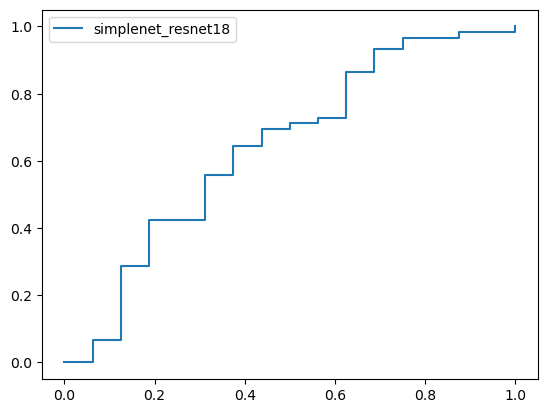

In [12]:
# exp_names = ['run59','run65']
exp_names = ['simplenet_resnet18']
for exp_name in exp_names:
    # config_path = "./configs/config_{}.json".format(exp_name)
    config_path = "./configs/config_cnn.json"
    config = process_config(config_path)
    SUBM_PREDS_PATH = "subm/{}_cat/{}_cat_wt_preds.csv".format(config.exp_name,config.exp_name)
    # print(SUBM_PREDS_PATH)
    summary_df = pd.read_csv(SUBM_PREDS_PATH, header=0)
    # display(summary_df)
    preds_score = summary_df['predict_scores'].tolist()
    # preds_score = [1-preds_score[i] for i in range(len(preds_score))]
    preds_label = summary_df['predict_label'].tolist()
    gt_label = summary_df['Label'].tolist()

    fpr, tpr, thresholds = roc_curve(gt_label,preds_score,pos_label=1)
    plt.plot(fpr,tpr,label=exp_name)
plt.legend()
plt.show()


# confusion matrix

Loaded configuration from  ./configs/config_cnn.json

{'TTA_folds': 3,
 'batch_size': 1,
 'clip_size': 256,
 'cosine_annealing': False,
 'dataloader': 'cv2dataloader',
 'decoder': 'LSTM',
 'decoder_dim': 256,
 'desc': 'simplenet with resnet18',
 'disc_exp_name': '',
 'drop_rate': 0,
 'epochs': 200,
 'es_patience': 150,
 'exclude_ext_data': False,
 'exp_name': 'simplenet_resnet18',
 'focal_gamma': 2,
 'force_subsample': False,
 'fp16': False,
 'group_drsl': False,
 'group_label': False,
 'imsize': 224,
 'lr': 0.001,
 'lr_patience': 50,
 'lr_scale': 0.1,
 'model_name': 'simplenet_resnet18',
 'model_type': '',
 'nclips': 1,
 'num_classes': 1,
 'num_workers': 4,
 'pos_weight': 1,
 'processed_run': '',
 'random_interval': False,
 'reduce_lr_plateau': True,
 'select': False,
 'spatial_attn': True,
 'spatial_attn_pool': False,
 'step_size': 4,
 'temporal_attention': True,
 'temporal_attention_softmax': True,
 'trajectory': False,
 'unfreeze_rgb': False,
 'use_rgb_base': True,
 'weighted_bce':

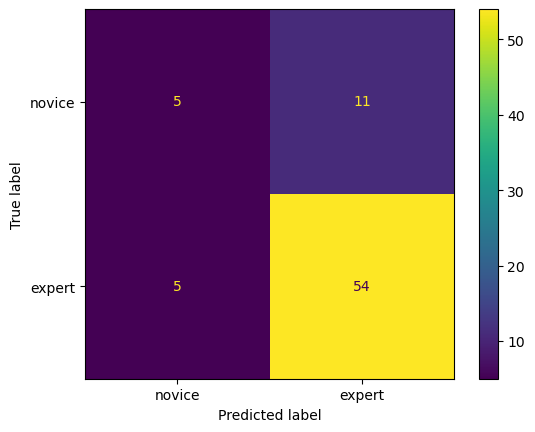

In [13]:
# config_path = "./configs/config.json"
config = process_config(config_path)
SUBM_PREDS_PATH = "subm/{}_cat/{}_cat_wt_preds.csv".format(config.exp_name,config.exp_name)
# print(SUBM_PREDS_PATH)
summary_df = pd.read_csv(SUBM_PREDS_PATH, header=0)
# display(summary_df)
preds_score = summary_df['predict_scores'].tolist()
# preds_score = [1-preds_score[i] for i in range(len(preds_score))]
preds_label = summary_df['predict_label'].tolist()
gt_label = summary_df['Label'].tolist()

cm = confusion_matrix(gt_label, preds_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['novice', 'expert'])
disp.plot()
plt.show()

## Below not used for now

### Generate report for each resident

In [5]:
resident_data_path = "./data/vid_901-953_w_resident_names.csv"
resident_data = pd.read_csv(resident_data_path,header=0)
config_path = "./configs/config_run20.json"
config = process_config(config_path)
ky_exp = is_ky(config)
#display(resident_data)
SUBM_OUT_PREDS = "./subm/{}/{}.csv".format(config.exp_name+"_cat",config.exp_name+"_cat_wt_preds")
print(SUBM_OUT_PREDS)
subm_cat_df = pd.read_csv(SUBM_OUT_PREDS,header=0)
# correct = [int(not (subm_cat_df.loc[i,'Label'] ^ subm_cat_df.loc[i,'predict_label'])) for i in range(len(subm_cat_df))]
# print(correct)
correct = ["N/A" for i in range(len(resident_data))]
for i in range(len(resident_data)):
    query = subm_cat_df.loc[subm_cat_df["Dir"].str.contains(str(resident_data.loc[i,'Video']))]
    if len(query)==1:
        query = query.reset_index()
        #display(query)
        correct[i] = str(int(not (query.loc[0,'Label']^query.loc[0,'predict_label'])))
    elif len(query)>1:
        print("ERROR: unexpected, query len > 1")

resident_data["correct"] = correct
resident_data['DOS'] = pd.to_datetime(resident_data['DOS'])
#resident_data.sort_values('DOS')
resident_data = resident_data.sort_values(by=['Resident Name','DOS'])
# resident_data = resident_data.sort_values(by=['DOS'])
resident_data_save_dir = "./statistics/{}/{}.csv".format(config.exp_name+"_cat","resident_report")
resident_data.to_csv(resident_data_save_dir,index=None)
display(resident_data)



Loaded configuration from  ./configs/config_run20.json

{'TTA_folds': 3,
 'attention': True,
 'attention_lambda': 0.5,
 'attention_loss': True,
 'batch_size': 2,
 'clip_size': 256,
 'concat_agg': False,
 'cosine_annealing': False,
 'dataloader': 'kpdataloader',
 'decoder_dim': 256,
 'desc': 'interpretable tempspatattnnet net with cohort2021, external for '
         'run17',
 'drop_rate': 0,
 'epochs': 1000,
 'es_patience': 100,
 'exclude_ext_data': False,
 'exp_name': 'ky_run20',
 'focal_gamma': 2,
 'force_subsample': False,
 'fp16': False,
 'group_drsl': False,
 'imsize': 256,
 'labels_path': 'rhexis54',
 'lr': 0.001,
 'lr_patience': 40,
 'lr_scale': 0.1,
 'model_name': 'intertempspatattnnet',
 'model_type': '',
 'nclips': 1,
 'num_classes': 1,
 'num_workers': 6,
 'processed_run': '',
 'reduce_lr_plateau': True,
 'select': False,
 'spatial_attn': True,
 'spatial_attn_pool': False,
 'step_size': 8,
 'temporal_attention': True,
 'temporal_attention_softmax': True,
 'trajectory': False,


,Video,Resident Name,Class of,Case #,DOS,correct
24,925,Inas Aboobakar,2020,7,2019-11-08,0
14,915,Inas Aboobakar,2020,10,2019-11-25,0
22,923,Inas Aboobakar,2020,61,2020-01-06,0
40,941,Inas Aboobakar,2020,73,2020-01-13,0
39,940,Inas Aboobakar,2020,102,2020-01-24,0
31,932,Inas Aboobakar,2020,118,2020-02-18,0
38,939,Ishrat Ahmed,2021,10,2020-09-16,0
20,921,Ishrat Ahmed,2021,75,2021-04-07,0
41,942,Ishrat Ahmed,2021,74,2021-04-07,0
46,947,Ishrat Ahmed,2021,93,2021-05-05,0


### Generate resident report with custom prediction threshold

In [8]:
resident_data_path = "./data/vid_901-953_w_resident_names.csv"
resident_data = pd.read_csv(resident_data_path,header=0)
config_path = "./configs/config_run41.json"
config = process_config(config_path)
ky_exp = is_ky(config)
threshold = 0.5
#display(resident_data)
SUBM_OUT_PREDS = "./subm/{}/{}.csv".format(config.exp_name+"_cat",config.exp_name+"_cat_wt_preds")
print(SUBM_OUT_PREDS)
subm_cat_df = pd.read_csv(SUBM_OUT_PREDS,header=0)
# correct = [int(not (subm_cat_df.loc[i,'Label'] ^ subm_cat_df.loc[i,'predict_label'])) for i in range(len(subm_cat_df))]
# print(correct)
ground_truth_path = "./data/new_all_labels.csv"
gt_df = pd.read_csv(ground_truth_path)
correct = ["N/A" for i in range(len(resident_data))]
ground_truth = [0 for _ in range(len(resident_data))]
for i in range(len(resident_data)):
    query = subm_cat_df.loc[subm_cat_df["Dir"].str.contains(str(resident_data.loc[i,'Video']))]
    gt_query = gt_df.loc[gt_df['Dir'].str.contains(str(resident_data.loc[i,'Video']))]
    if len(query)==1 and len(gt_query)==1:
        gt_query = gt_query.reset_index()
        query = query.reset_index()
        #display(query)
        predict_label_threshold = int(query.loc[0,'predict_scores']>threshold)
        correct[i] = str(int(not (query.loc[0,'Label']^predict_label_threshold)))
        ground_truth[i] = str(gt_query.loc[0,'Label'])
    elif len(query)>1 or len(gt_query)>1:
        print("ERROR: unexpected, query len: {}, gt_query len: {}".format(len(query), len(gt_query)))

resident_data["Correct"] = correct
resident_data["Ground Truth"] = ground_truth
resident_data['DOS'] = pd.to_datetime(resident_data['DOS'])
#resident_data.sort_values('DOS')
resident_data = resident_data.sort_values(by=['Resident Name','DOS'])
# resident_data = resident_data.sort_values(by=['DOS'])
resident_data_save_dir = "./statistics/{}/{}.csv".format(config.exp_name+"_cat","resident_report")
resident_data.to_csv(resident_data_save_dir,index=None)
display(resident_data)



Loaded configuration from  ./configs/config_run41.json

{'TTA_folds': 3,
 'attention': True,
 'attention_lambda': 1.0,
 'attention_loss': False,
 'batch_size': 2,
 'clip_size': 256,
 'cosine_annealing': False,
 'dataloader': 'mixed_dataloader',
 'decoder_dim': 1024,
 'desc': 'interpretable tempspatattnnet net without attention loss with '
         'rhexis54, identical to run35, copied from run39, changed '
         'gdrsl_adverser.py, corrected the calculation of z1=(9-8z0).',
 'drop_rate': 0,
 'epochs': 1000,
 'es_patience': 100,
 'exclude_ext_data': False,
 'exp_name': 'run41',
 'focal_gamma': 2,
 'force_subsample': False,
 'fp16': False,
 'group_drsl': True,
 'imsize': 256,
 'labels_path': 'rhexis54',
 'lr': 0.001,
 'lr_patience': 40,
 'lr_scale': 0.1,
 'model_name': 'intertempspatattnnet',
 'model_type': '',
 'nclips': 1,
 'num_classes': 1,
 'num_workers': 6,
 'pos_weight': 1,
 'processed_run': '',
 'reduce_lr_plateau': True,
 'select': False,
 'spatial_attn': False,
 'spatial_attn

,Video,Resident Name,Class of,Case #,DOS,Correct,Ground Truth
24,925,Inas Aboobakar,2020,7,2019-11-08,1,0
14,915,Inas Aboobakar,2020,10,2019-11-25,1,0
22,923,Inas Aboobakar,2020,61,2020-01-06,N/A,0
40,941,Inas Aboobakar,2020,73,2020-01-13,N/A,0
39,940,Inas Aboobakar,2020,102,2020-01-24,1,0
31,932,Inas Aboobakar,2020,118,2020-02-18,N/A,0
38,939,Ishrat Ahmed,2021,10,2020-09-16,N/A,0
20,921,Ishrat Ahmed,2021,75,2021-04-07,1,0
41,942,Ishrat Ahmed,2021,74,2021-04-07,1,0
46,947,Ishrat Ahmed,2021,93,2021-05-05,0,0
